# Module 9 Assignment 1: Natural Language Processing with Disaster Tweets
The goal of this project is to develop a model that Predict which Tweets are about real disasters and which ones are not

**Sachin Sharma**

**MSDS-422**

**08/14/2024**

## Management/Research Question
In layman’s terms, what is the management/research question of interest, and why would anyone care?

Requirements
1. Conduct your analysis using a cross-validation design.
2. Conduct EDA.
3. Build at least three RNN models based on hyperparameter tuning.
4. Evaluate goodness of fit metrics.
5. Once you have your best-performing models, classify the test data and submit it to Kaggle. Provide your Kaggle.com user name and screen snapshots of your scores.
6. Discuss your model’s performance.

### Import Libraries

In [55]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS
import string
import warnings
warnings.filterwarnings("ignore")
from collections import  Counter
from sklearn.feature_extraction.text import CountVectorizer

import torch
from tensorflow.python.client import device_lib
from tensorflow.config import list_physical_devices
from torch import cuda
import random

import nltk
# nltk.download('stopwords') one time activity
# nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D,
                          Input)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras import Input

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score,
    confusion_matrix
)
from sklearn.model_selection import train_test_split

import transformers
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from transformers import TFBertModel
from sklearn.model_selection import KFold

In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-08-13 05:09:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-08-13 05:09:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-08-13 05:09:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [3]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [4]:
ls

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip          sample_data/
glove.6B.200d.txt  glove.6B.50d.txt   nlp-getting-started/


### EDA

In [5]:
df_train = pd.read_csv('nlp-getting-started/train.csv')
df_test = pd.read_csv('nlp-getting-started/test.csv')

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))
train_df = df_train.copy()
test_df = df_test.copy()

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


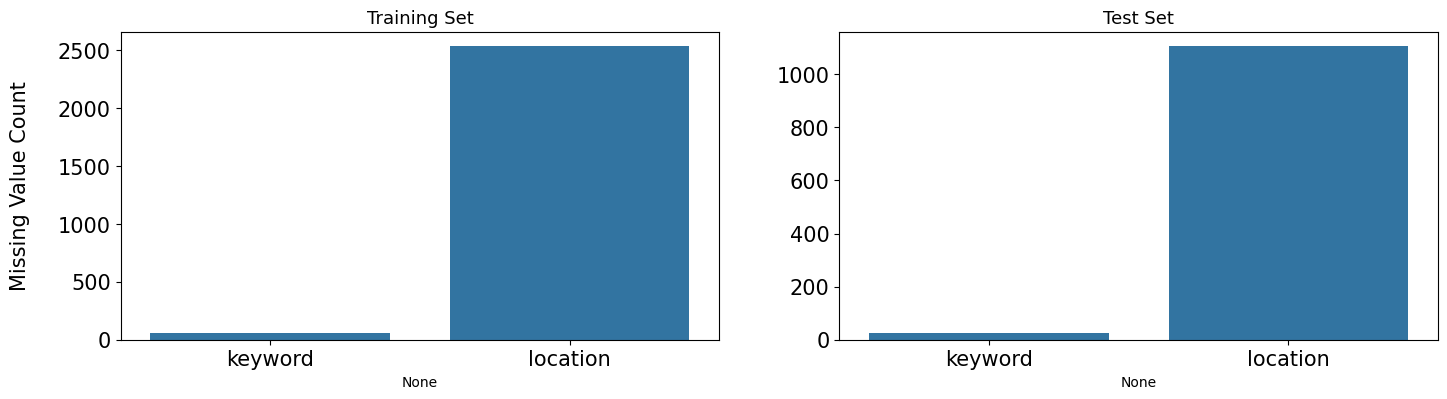

In [6]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

Missing Values

Both training and test set have same ratio of missing values in keyword and location

In [7]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


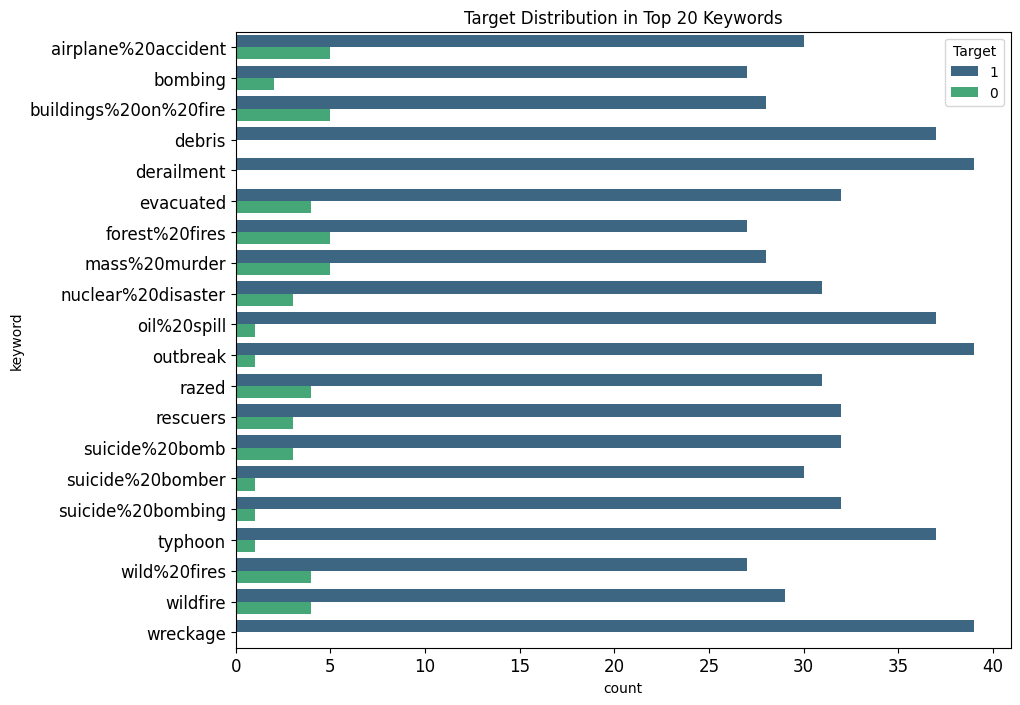

In [8]:
# Temporary conversion of target to string for plotting
df_train['target_str'] = df_train['target'].astype(str)

# Calculate target mean
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

# Sort by target mean and select top 20 keywords
top_keywords = df_train[['keyword', 'target_mean']].drop_duplicates().sort_values(by='target_mean', ascending=False).head(20)

# Filter the DataFrame to include only top keywords
df_top_keywords = df_train[df_train['keyword'].isin(top_keywords['keyword'])]

# Plot
plt.figure(figsize=(10, 8), dpi=100)
sns.countplot(y=df_top_keywords['keyword'], hue=df_top_keywords['target_str'], palette="viridis")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1, title="Target")
plt.title('Target Distribution in Top 20 Keywords')

plt.show()

# # Clean up
df_train.drop(columns=['target_mean'], inplace=True)

In [9]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

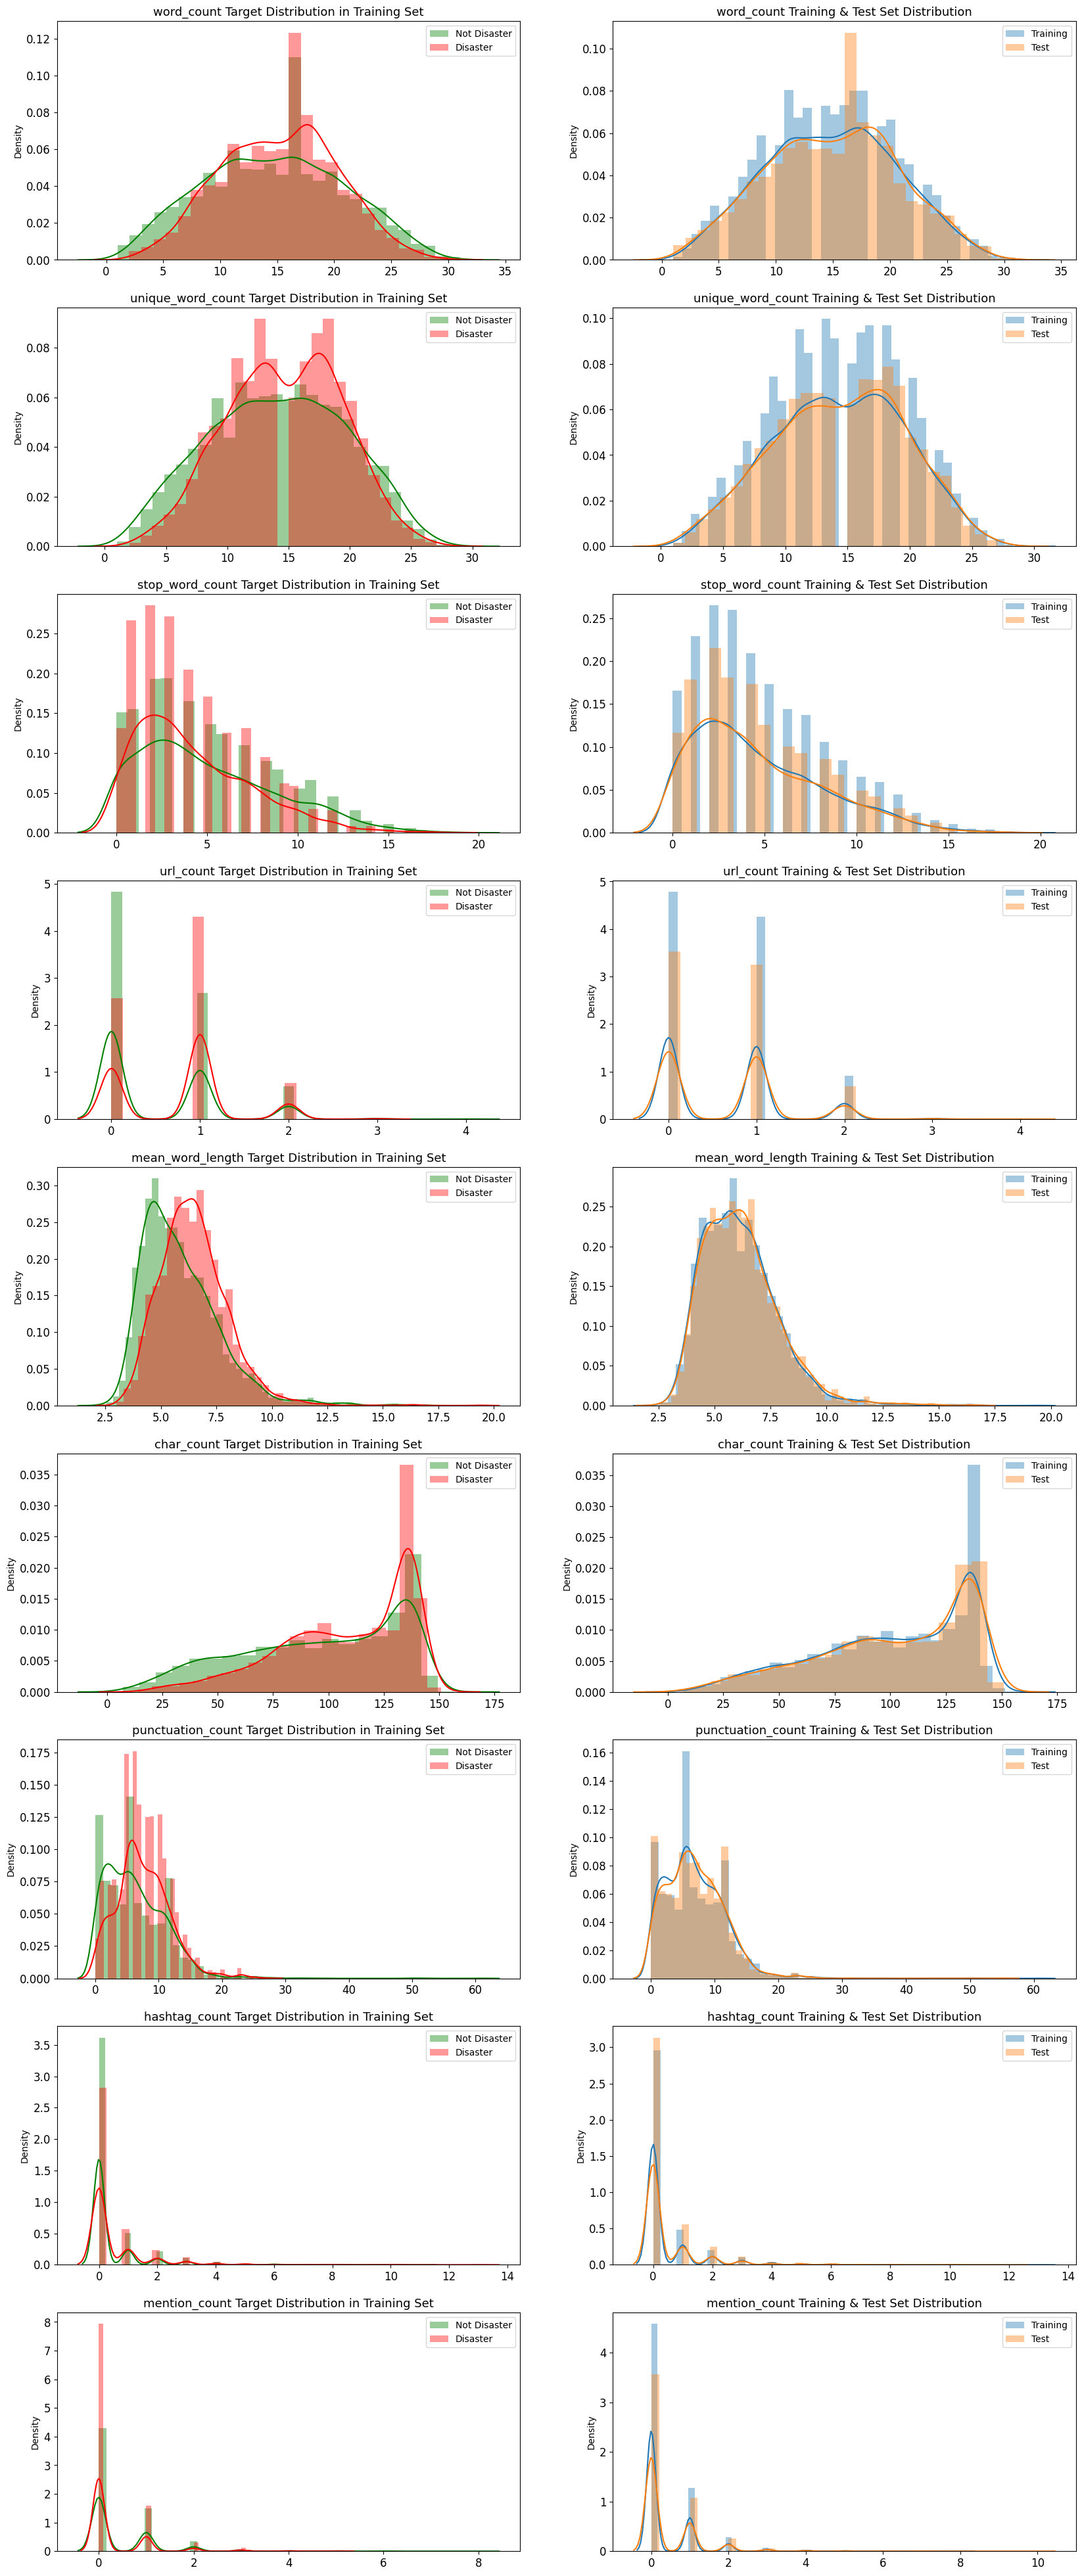

In [10]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

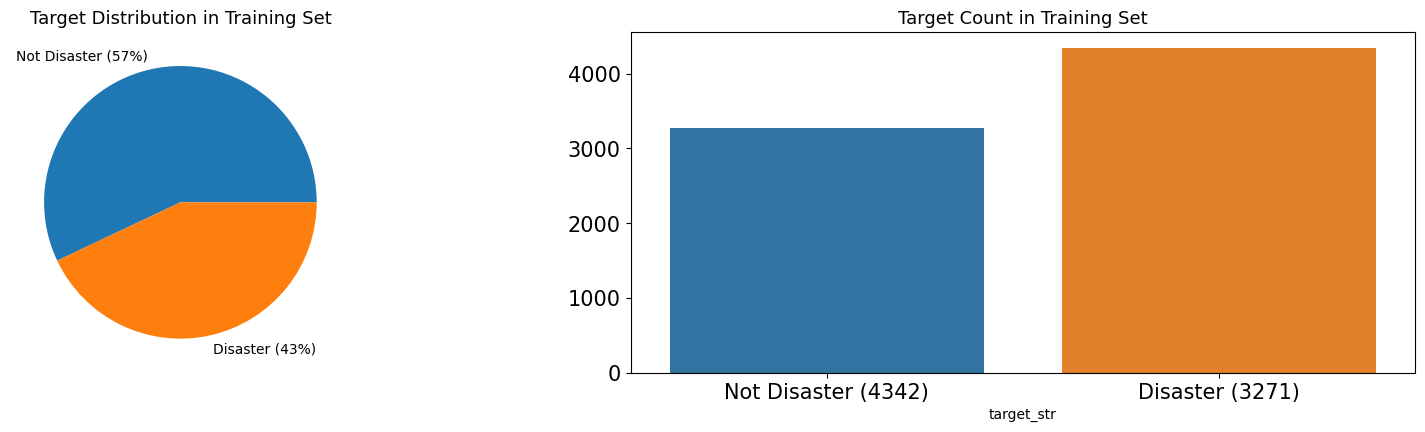

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target_str').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df_train['target_str'], hue=df_train['target_str'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

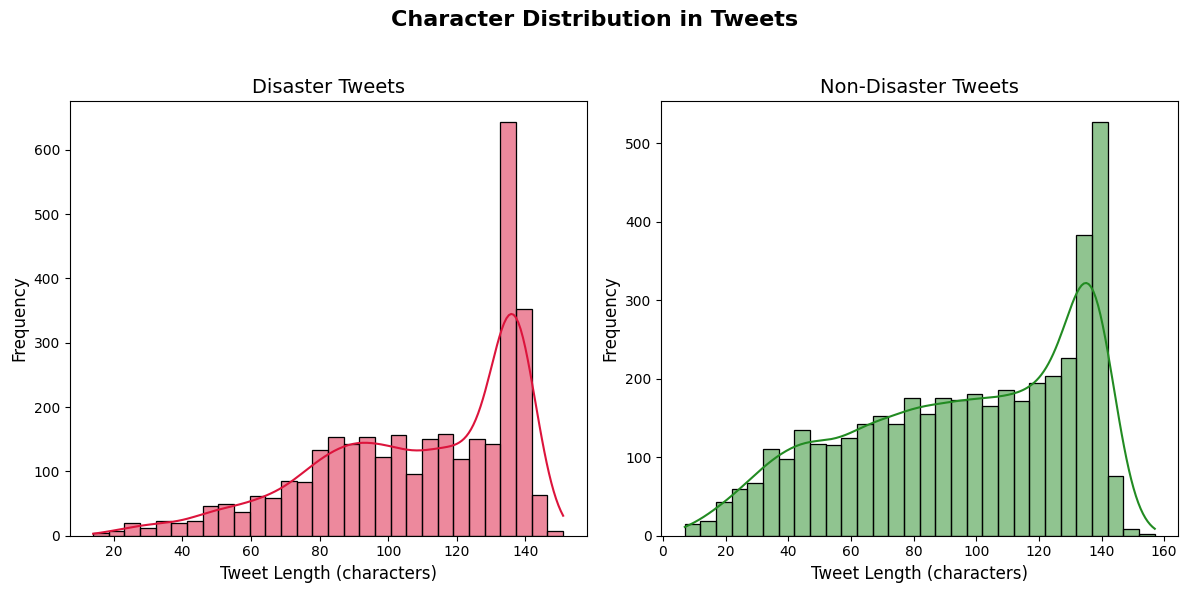

In [12]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the length of disaster tweets
tweet_len_disaster = df_train[df_train['target'] == 1]['text'].str.len()
sns.histplot(tweet_len_disaster, bins=30, kde=True, color='crimson', ax=ax1)
ax1.set_title('Disaster Tweets', fontsize=14)
ax1.set_xlabel('Tweet Length (characters)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)

# Plot the length of non-disaster tweets
tweet_len_non_disaster = df_train[df_train['target'] == 0]['text'].str.len()
sns.histplot(tweet_len_non_disaster, bins=30, kde=True, color='forestgreen', ax=ax2)
ax2.set_title('Non-Disaster Tweets', fontsize=14)
ax2.set_xlabel('Tweet Length (characters)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)

# Set a common title for the figure
fig.suptitle('Character Distribution in Tweets', fontsize=16, fontweight='bold')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

In [13]:
# Use STOPWORDS from the wordcloud library
stop = STOPWORDS

def create_corpus(target):
    corpus = []
    for x in df_train[df_train['target_str'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

# Create corpus for non-disaster tweets

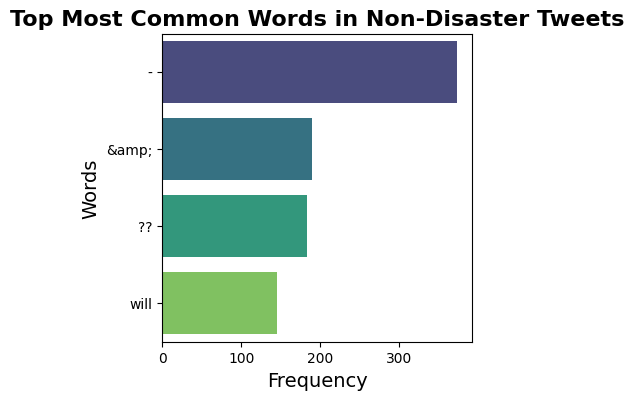

In [14]:
corpus = create_corpus('0')  # Using string '0' because of earlier conversion
counter = Counter(corpus)
most = counter.most_common()

# Prepare data for plotting
x = []
y = []
for word, count in most[:50]:  # Top 50 words
    if word.lower() not in stop:
        x.append(word)
        y.append(count)

# Plot the data
plt.figure(figsize=(4, 4))
sns.barplot(x=y, y=x, palette="viridis", ci=None)
plt.title('Top Most Common Words in Non-Disaster Tweets', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.show()

In [15]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


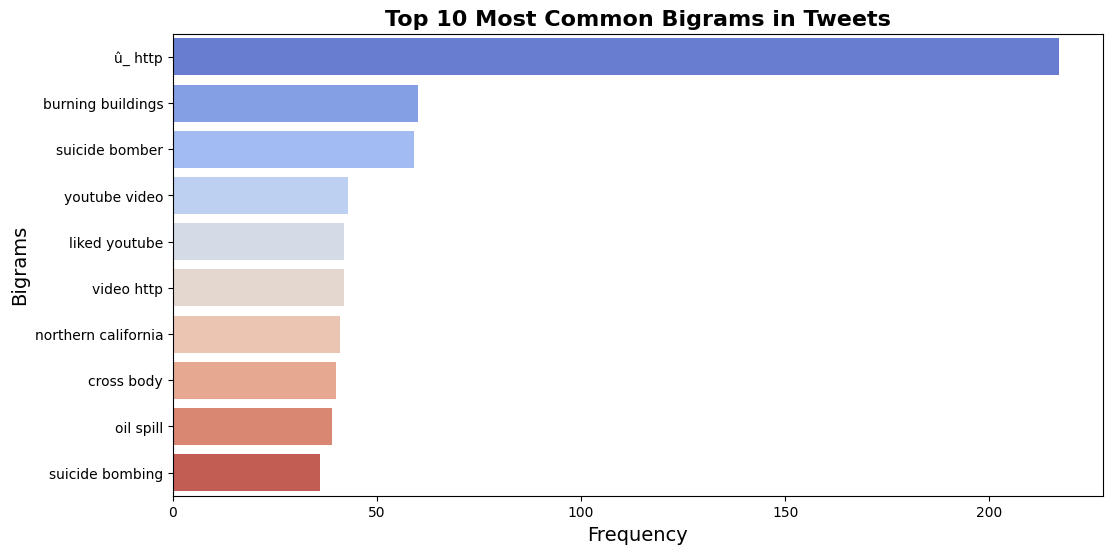

In [16]:
# Extract the top 10 bigrams
top_tweet_bigrams = get_top_tweet_bigrams(df_train['text'], n=10)

# Separate bigrams and their frequencies
x, y = zip(*top_tweet_bigrams)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(y), y=list(x), palette="coolwarm")
plt.title('Top 10 Most Common Bigrams in Tweets', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Bigrams', fontsize=14)
plt.show()

# Clean up
df_train.drop(columns=['target_str'], inplace=True)

### Model Building

Data Prep

In [17]:
list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17806966287802526317
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9881401946061084862
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [19]:
train_df = train_df.dropna(how="any", axis=1)

In [22]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# https://www.kaggle.com/tanulsingh077
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
        '',
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)

    return text

def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords and Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)

    return text

stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

stemmer = nltk.SnowballStemmer("english")

test_df['text_clean'] = test_df['text'].apply(preprocess_data)

train_df['text_clean'] = train_df['text'].apply(preprocess_data)
train_df.head()

,id,text,target,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,7,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


In [25]:
train_tweets = train_df['text_clean'].values
test_tweets = test_df['text_clean'].values
train_target = train_df['target'].values

# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweets),
    length_long_sentence,
    padding='post'
)

test_padded_sentences = pad_sequences(
    embed(test_tweets),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[3635,  467,  201, ...,    0,    0,    0],
       [ 137,    2,  106, ...,    0,    0,    0],
       [1338,  502, 1806, ...,    0,    0,    0],
       ...,
       [ 448, 1328,    0, ...,    0,    0,    0],
       [  28,  162, 2636, ...,    0,    0,    0],
       [ 171,   31,  413, ...,    0,    0,    0]], dtype=int32)

In [70]:
#KFOLD
# Parameters
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

#### Model 1: GLoVe-LSTM 100D

In [27]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('glove.6B.100d.txt', encoding="utf8") as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [28]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [31]:
def glove_lstm_100():
    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence
    ))

    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = glove_lstm_100()

In [57]:
model_glove_lstm_filename = 'model_glove_lstm_100.keras'
# Lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

In [58]:
# K-Fold Cross Validation
for train_index, val_index in kf.split(train_padded_sentences):
    X_train_fold, X_val_fold = train_padded_sentences[train_index], train_padded_sentences[val_index]
    y_train_fold, y_val_fold = train_target[train_index], train_target[val_index]

    model_glove_lstm = glove_lstm_100()  # Instantiate a new model for each fold

    checkpoint = ModelCheckpoint(
        model_glove_lstm_filename,
        monitor='val_loss',
        verbose=1,
        save_best_only=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        verbose=1,
        patience=5,
        min_lr=0.001
    )

    history_glove_lstm = model_glove_lstm.fit(
        X_train_fold,
        y_train_fold,
        epochs=10,
        batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        verbose=1,
        callbacks=[reduce_lr, checkpoint]
    )

    # Load the best model from this fold
    model_final = load_model(model_glove_lstm_filename)
    y_pred = (model_final.predict(X_val_fold) > 0.5).astype("int32")

    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred))
    precision_scores.append(precision_score(y_val_fold, y_pred))
    recall_scores.append(recall_score(y_val_fold, y_pred))
    f1_scores.append(f1_score(y_val_fold, y_pred))

    print(f"Fold completed with Accuracy: {accuracy_scores[-1]}, Precision: {precision_scores[-1]}, Recall: {recall_scores[-1]}, F1-Score: {f1_scores[-1]}")
    print('-'*50)

# Compute average performance across all folds
print(f"Average Accuracy: {np.mean(accuracy_scores)}")
print(f"Average Precision: {np.mean(precision_scores)}")
print(f"Average Recall: {np.mean(recall_scores)}")
print(f"Average F1-Score: {np.mean(f1_scores)}")

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5678 - loss: 0.8934
Epoch 1: val_loss improved from inf to 0.65101, saving model to model_glove_lstm_100.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.5679 - loss: 0.8929 - val_accuracy: 0.6678 - val_loss: 0.6510 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6453 - loss: 0.6565
Epoch 2: val_loss improved from 0.65101 to 0.53583, saving model to model_glove_lstm_100.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - accuracy: 0.6454 - loss: 0.6563 - val_accuracy: 0.7787 - val_loss: 0.5358 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7169 - loss: 0.5701
Epoch 3: val_loss improved from 0.53583 to 0.48140, saving model to model_glove_lstm_100.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.7169 - loss: 0.5700 - val_accuracy: 0.7912 - val_loss: 0.4814 - learning_rate: 0.0010
Epoch 4/10
191/191 ━━━━━━

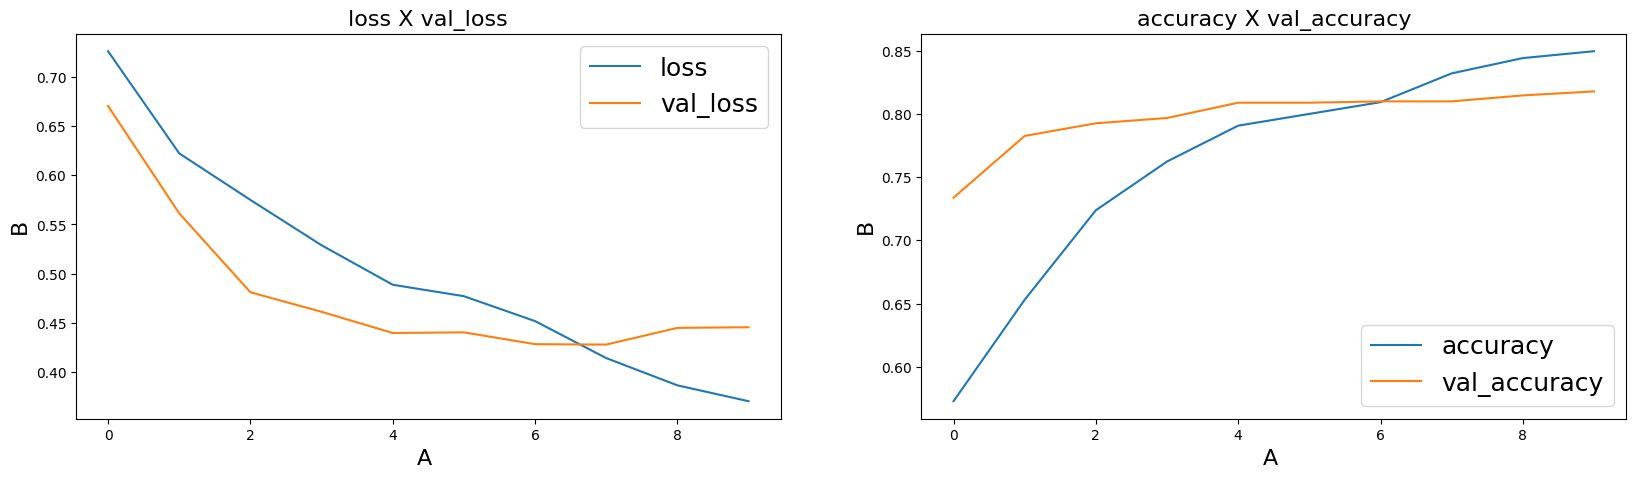

In [34]:
plot_learning_curves(history_glove_lstm, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [35]:
model_glove_lstm_final = load_model(model_glove_lstm_filename)
y_pred_glove_lstm = (model_glove_lstm_final.predict(X_val) > 0.5).astype("int32")

cm = confusion_matrix(y_val,y_pred_glove_lstm)
print('confusion matrix:\n',cm)
print(classification_report(y_val, y_pred_glove_lstm))

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
confusion matrix:
 [[967 104]
 [258 575]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1071
           1       0.85      0.69      0.76       833

    accuracy                           0.81      1904
   macro avg       0.82      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



Submission

In [36]:
y_glove_lstm = (model_glove_lstm_final.predict(test_padded_sentences) > 0.5).astype("int32")
y_labels = []
for i in range (0, len(y_glove_lstm)):
    y_labels.append(y_glove_lstm[i][0])

# create submission file
submission_glove_lstm = pd.DataFrame({"id": (test_df['id']),"target": y_labels})
submission_glove_lstm.to_csv('submission_glove_lstm_100.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


#### Model 2: GLoVe-LSTM 200D

In [59]:
embeddings_dictionary = dict()
embedding_dim = 200

# Load GloVe 200D embeddings
with open('glove.6B.200d.txt', encoding="utf8") as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [60]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [61]:
def glove_lstm_200():
    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence
    ))

    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = glove_lstm_200()

In [62]:
model_glove_lstm_filename = 'model_glove_lstm_200.keras'
# Lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

In [63]:
# K-Fold Cross Validation
for train_index, val_index in kf.split(train_padded_sentences):
    X_train_fold, X_val_fold = train_padded_sentences[train_index], train_padded_sentences[val_index]
    y_train_fold, y_val_fold = train_target[train_index], train_target[val_index]

    model_glove_lstm = glove_lstm_200()  # Instantiate a new model for each fold

    checkpoint = ModelCheckpoint(
        model_glove_lstm_filename,
        monitor='val_loss',
        verbose=1,
        save_best_only=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        verbose=1,
        patience=5,
        min_lr=0.001
    )

    history_glove_lstm = model_glove_lstm.fit(
        X_train_fold,
        y_train_fold,
        epochs=10,
        batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        verbose=1,
        callbacks=[reduce_lr, checkpoint]
    )

    # Load the best model from this fold
    model_final = load_model(model_glove_lstm_filename)
    y_pred = (model_final.predict(X_val_fold) > 0.5).astype("int32")

    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred))
    precision_scores.append(precision_score(y_val_fold, y_pred))
    recall_scores.append(recall_score(y_val_fold, y_pred))
    f1_scores.append(f1_score(y_val_fold, y_pred))

    print(f"Fold completed with Accuracy: {accuracy_scores[-1]}, Precision: {precision_scores[-1]}, Recall: {recall_scores[-1]}, F1-Score: {f1_scores[-1]}")
    print('-'*50)

# Compute average performance across all folds
print(f"Average Accuracy: {np.mean(accuracy_scores)}")
print(f"Average Precision: {np.mean(precision_scores)}")
print(f"Average Recall: {np.mean(recall_scores)}")
print(f"Average F1-Score: {np.mean(f1_scores)}")

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5617 - loss: 0.8135
Epoch 1: val_loss improved from inf to 0.65057, saving model to model_glove_lstm_200.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - accuracy: 0.5618 - loss: 0.8132 - val_accuracy: 0.7472 - val_loss: 0.6506 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6253 - loss: 0.6594
Epoch 2: val_loss improved from 0.65057 to 0.56502, saving model to model_glove_lstm_200.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.6255 - loss: 0.6592 - val_accuracy: 0.7800 - val_loss: 0.5650 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7114 - loss: 0.5910
Epoch 3: val_loss improved from 0.56502 to 0.49223, saving model to model_glove_lstm_200.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.7115 - loss: 0.5909 - val_accuracy: 0.7932 - val_loss: 0.4922 - learning_rate: 0.0010
Epoch 4/10
191/191 ━━━━━━━

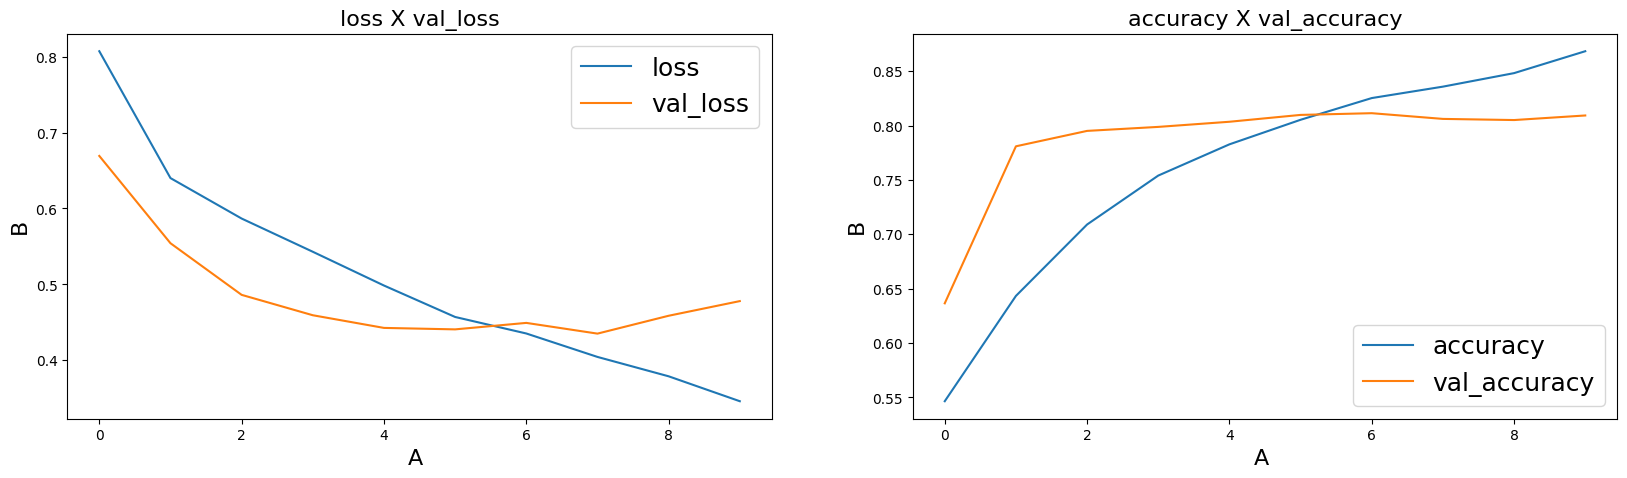

In [44]:
plot_learning_curves(history_glove_lstm, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [45]:
model_glove_lstm_final = load_model(model_glove_lstm_filename)
y_pred_glove_lstm = (model_glove_lstm_final.predict(X_val) > 0.5).astype("int32")
cm = confusion_matrix(y_val,y_pred_glove_lstm)
print('confusion matrix:\n',cm)
print(classification_report(y_val, y_pred_glove_lstm))

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
confusion matrix:
 [[991  80]
 [289 544]]
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1071
           1       0.87      0.65      0.75       833

    accuracy                           0.81      1904
   macro avg       0.82      0.79      0.79      1904
weighted avg       0.82      0.81      0.80      1904



Submission

In [46]:
y_glove_lstm = (model_glove_lstm_final.predict(test_padded_sentences) > 0.5).astype("int32")
y_labels = []
for i in range (0, len(y_glove_lstm)):
    y_labels.append(y_glove_lstm[i][0])

# create submission file
submission_glove_lstm = pd.DataFrame({"id": (test_df['id']),"target": y_labels})
submission_glove_lstm.to_csv('submission_glove_lstm_200.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


#### Model 3: GLoVe-LSTM 300D

In [65]:
embeddings_dictionary = dict()
embedding_dim = 300

# Load GloVe 300D embeddings
with open('glove.6B.300d.txt', encoding="utf8") as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions



In [66]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [67]:
def glove_lstm_300():
    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence
    ))

    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = glove_lstm_300()

In [68]:
model_glove_lstm_filename = 'model_glove_lstm_300.keras'
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

In [69]:
# K-Fold Cross Validation
for train_index, val_index in kf.split(train_padded_sentences):
    X_train_fold, X_val_fold = train_padded_sentences[train_index], train_padded_sentences[val_index]
    y_train_fold, y_val_fold = train_target[train_index], train_target[val_index]

    model_glove_lstm = glove_lstm_300()  # Instantiate a new model for each fold

    checkpoint = ModelCheckpoint(
        model_glove_lstm_filename,
        monitor='val_loss',
        verbose=1,
        save_best_only=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        verbose=1,
        patience=5,
        min_lr=0.001
    )

    history_glove_lstm = model_glove_lstm.fit(
        X_train_fold,
        y_train_fold,
        epochs=10,
        batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        verbose=1,
        callbacks=[reduce_lr, checkpoint]
    )

    # Load the best model from this fold
    model_final = load_model(model_glove_lstm_filename)
    y_pred = (model_final.predict(X_val_fold) > 0.5).astype("int32")

    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred))
    precision_scores.append(precision_score(y_val_fold, y_pred))
    recall_scores.append(recall_score(y_val_fold, y_pred))
    f1_scores.append(f1_score(y_val_fold, y_pred))

    print(f"Fold completed with Accuracy: {accuracy_scores[-1]}, Precision: {precision_scores[-1]}, Recall: {recall_scores[-1]}, F1-Score: {f1_scores[-1]}")
    print('-'*50)

# Compute average performance across all folds
print(f"Average Accuracy: {np.mean(accuracy_scores)}")
print(f"Average Precision: {np.mean(precision_scores)}")
print(f"Average Recall: {np.mean(recall_scores)}")
print(f"Average F1-Score: {np.mean(f1_scores)}")

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5362 - loss: 0.9592
Epoch 1: val_loss improved from inf to 0.64454, saving model to model_glove_lstm_300.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - accuracy: 0.5363 - loss: 0.9586 - val_accuracy: 0.7242 - val_loss: 0.6445 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6540 - loss: 0.6429
Epoch 2: val_loss improved from 0.64454 to 0.53397, saving model to model_glove_lstm_300.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.6541 - loss: 0.6427 - val_accuracy: 0.7748 - val_loss: 0.5340 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7359 - loss: 0.5549
Epoch 3: val_loss improved from 0.53397 to 0.45968, saving model to model_glove_lstm_300.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.7360 - loss: 0.5549 - val_accuracy: 0.8004 - val_loss: 0.4597 - learning_rate: 0.0010
Epoch 4/10
191/191 ━━━━━━

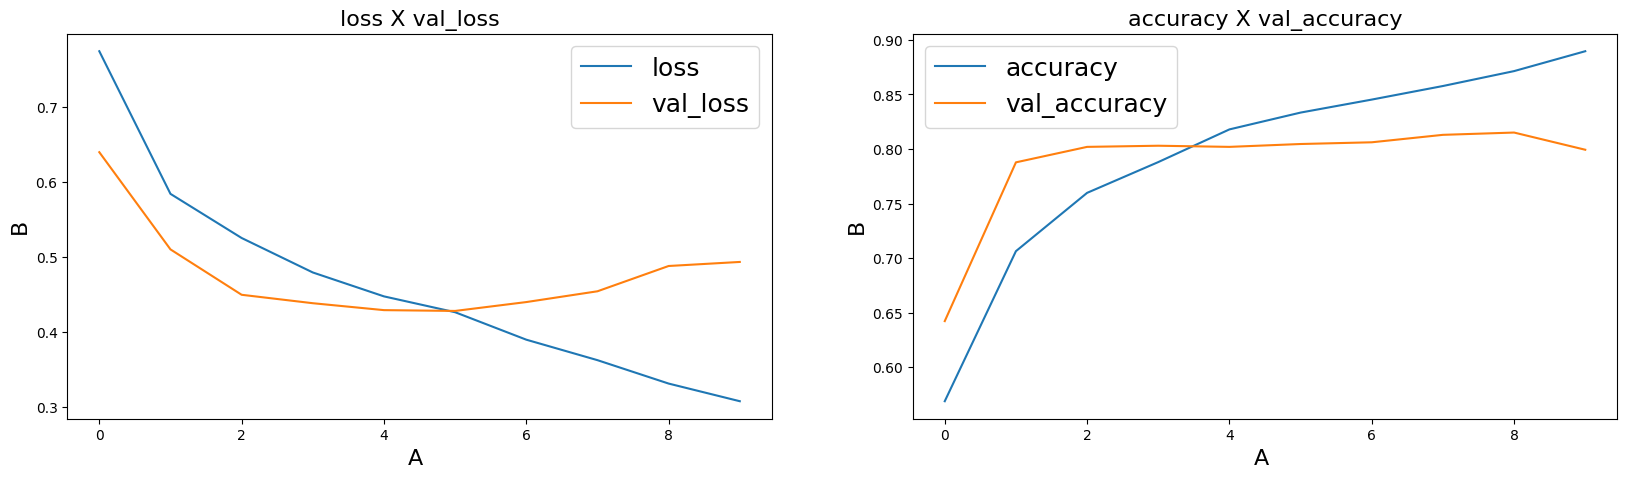

In [52]:
plot_learning_curves(history_glove_lstm, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [53]:
model_glove_lstm_final = load_model(model_glove_lstm_filename)
y_pred_glove_lstm = (model_glove_lstm_final.predict(X_val) > 0.5).astype("int32")
cm = confusion_matrix(y_val,y_pred_glove_lstm)
print('confusion matrix:\n',cm)
print(classification_report(y_val, y_pred_glove_lstm))

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
confusion matrix:
 [[1001   70]
 [ 302  531]]
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1071
           1       0.88      0.64      0.74       833

    accuracy                           0.80      1904
   macro avg       0.83      0.79      0.79      1904
weighted avg       0.82      0.80      0.80      1904



Submission

In [54]:
y_glove_lstm = (model_glove_lstm_final.predict(test_padded_sentences) > 0.5).astype("int32")
y_labels = []
for i in range (0, len(y_glove_lstm)):
    y_labels.append(y_glove_lstm[i][0])

# create submission file
submission_glove_lstm = pd.DataFrame({"id": (test_df['id']),"target": y_labels})
submission_glove_lstm.to_csv('submission_glove_lstm_300.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


The management or research question for this project is: "**How can we accurately determine if a tweet is about a real disaster or not?**"

Why is this important?

In today's world, where information flows rapidly through social media platforms like Twitter, it's crucial for disaster relief organizations, news agencies, and emergency services to quickly and accurately identify genuine disaster-related tweets. These tweets can provide real-time information during emergencies, helping to mobilize resources, provide timely assistance, and potentially save lives.

However, not all tweets that mention disasters are actually about real events. Some may use disaster-related language metaphorically or humorously, which can confuse automated systems. By developing a model that can reliably distinguish between real disaster tweets and those that aren't, we can ensure that critical information reaches the right people at the right time, making response efforts more effective and efficient.